# K-Nearest Neighbors Genre Classifier

### Train-Test Split the Songs
It is important to create a train-test split of the songs *before* the splitting each song into three-second segments as to avoid mixing segments of the test songs into the actual training set.

In [16]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
from matplotlib import pyplot as plt

# Load datasets
df_songs = pd.read_csv('../data/features_30_sec.csv')
df_segments = pd.read_csv('../data/features_3_sec.csv')

# Prepare training and testing data
X = df_songs
y = df_songs['label']

X_train_songs, X_test_songs, y_train_songs, y_test_songs = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_filenames = X_train_songs['filename']
test_filenames = X_test_songs['filename']

Given the song names in the train set and test set, it is necessary to get all 3-second segments corresponding to each song. In the CSV files, the full songs are in the format **[Genre].[Song Number].wav** whereas the segmented songs are in the format **[Genre].[Song Number].[Segment].wav**, so the segments can be extracted using some RegEx to get a mask.

In [17]:
train_mask = (df_segments['filename'].str.extract(r'(.*\.\d+)\.\d+\.wav')[0] + '.wav').isin(train_filenames)
test_mask = (df_segments['filename'].str.extract(r'(.*\.\d+)\.\d+\.wav')[0] + '.wav').isin(test_filenames)

df_train_segments = df_segments[train_mask].reset_index(drop=True)
df_test_segments = df_segments[test_mask].reset_index(drop=True)

### Drop Unnecessary Columns
The name of the file is obviously cheating, and all songs have roughly the same length (give or take a few frames), so the length is also an unnecessary column. The label is what is being predicted, so it is also dropped.

In [18]:
X_train_segments = df_train_segments.drop(columns=['filename', 'length', 'label'])
y_train_segments = df_train_segments['label']

## Model Selection

### Model Parameter Selection

In [19]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [20]:
# Define parameter grid for GridSearchCV
param_grid = {
    'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_segments, y_train_segments)

# Print best parameters and best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

Best parameters found: {'knn__n_neighbors': 9}
Best cross-validation accuracy: 0.5035043804755945


## Evaluation

Classification Report:
              precision    recall  f1-score   support

       blues       0.88      0.70      0.78        20
   classical       0.87      1.00      0.93        20
     country       0.72      0.90      0.80        20
       disco       0.62      0.75      0.68        20
      hiphop       0.68      0.65      0.67        20
        jazz       0.83      0.75      0.79        20
       metal       0.88      0.75      0.81        20
         pop       0.81      0.85      0.83        20
      reggae       0.63      0.60      0.62        20
        rock       0.72      0.65      0.68        20

    accuracy                           0.76       200
   macro avg       0.77      0.76      0.76       200
weighted avg       0.77      0.76      0.76       200

Accuracy Score:
0.76


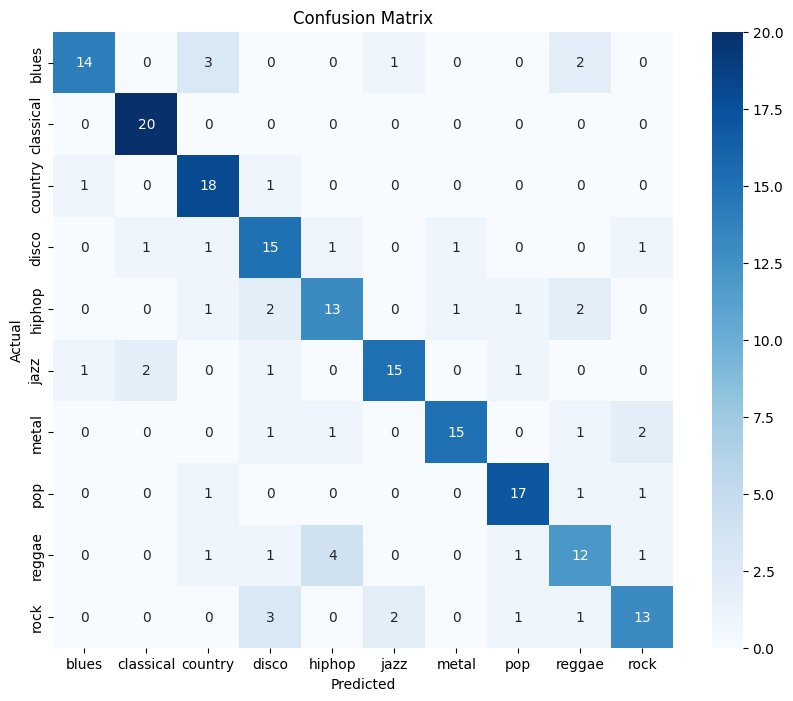

In [21]:
# Use the best estimator to predict on test set
best_clf = grid_search.best_estimator_
X_test_segments = df_test_segments.drop(columns=['filename', 'length', 'label'])
y_test_segments = df_test_segments['label']

y_pred = best_clf.predict(X_test_segments)

# Define majority vote function
def majority_vote(predictions):
    return predictions.mode().iloc[0]

df_test_segments['predicted_label'] = y_pred

df_test_segments['song'] = df_test_segments['filename'].str.extract(r'(.*\.\d{5})')[0] + '.wav'
song_predictions = df_test_segments.groupby('song')['predicted_label'].apply(majority_vote)

song_true_labels = X_test_songs.set_index('filename').loc[song_predictions.index, 'label']
song_pred_labels = song_predictions

# Print classification report and accuracy score
print("Classification Report:")
print(classification_report(song_true_labels, song_pred_labels))

print("Accuracy Score:")
print(accuracy_score(song_true_labels, song_pred_labels))

cm = confusion_matrix(song_true_labels, song_predictions, labels=song_true_labels.unique())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=song_true_labels.unique(), yticklabels=song_true_labels.unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()